# 3. Análise Exploratória de Dados (Exploratory Data Analysis)

**Objetivo:** Identificar os principais drivers de inadimplência (`TARGET = 1`) e validar hipóteses de negócio, confirmando se as variáveis tratadas e criadas na etapa anterior carregam sinal preditivo real.

**Contexto (CRISP-DM):** Com os dados limpos e enriquecidos (*Data Preparation*), avançamos para a fase de **Validação de Hipóteses**. No ciclo CRISP-DM, esta etapa serve como filtro entre a preparação e a modelagem: precisamos garantir que nossas variáveis distinguem claramente o comportamento de bons e maus pagadores.

**Estratégia de Análise:** Utilizaremos uma abordagem híbrida de "Focus & Scan":
* **Focus (Hipóteses de Negócio):** Análise aprofundada das variáveis de maior impacto para responder perguntas diretas de negócio.
* **Scan (Varredura de Perfil):** Visualização em grade das variáveis secundárias para garantir que nenhum padrão periférico seja ignorado.

**Etapas deste Notebook:**

1.  **Definição do Baseline (Target):** Cálculo da Taxa Média Global de Inadimplência.
2.  **Teste de Hipóteses Principais (Focus):**
    * *H1 - Maturidade:* A idade influencia o pagamento?
    * *H2 - Capacidade:* O comprometimento de renda (`DEBT_TO_INCOME`) é decisivo?
    * *H3 - Estabilidade:* A transparência na profissão altera o risco?
    * *H4 - Social:* Educação é fator discriminante?
    * *H5 - Histórico:* Os Scores Externos (`EXT_SOURCE`) realmente predizem o risco?
3.  **Análise de Perfil Secundário (Scan):** Varredura demográfica e patrimonial.
4.  **Correlações Multivariadas:** Ranking de importância das variáveis numéricas.

## 3.1 Importação de Bibliotecas e Configurações

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Show all columns when displaying a DataFrame
pd.set_option('display.max_columns', None)

sns.set_style('darkgrid')

### 3.1.1 Carregando o Dataset (Limpo)

In [164]:
df = pd.read_csv('../data/processed/application_train_cleaned.csv')

## 3.2 Definição da Baseline (Target)

Para contextualizar todas as análises subsequentes, precisamos estabelecer a **Taxa Média de Inadimplência** do dataset.

* **Por que isso é importante?** Ao analisarmos segmentos específicos (ex: "Clientes com Ensino Superior"), compararemos a taxa desse grupo contra a média global.
* **A Regra:** Se um segmento possui taxa de inadimplência significativamente superior à média global, ele é considerado um **Grupo de Risco**.

In [165]:
# 1. Calculating the overall default rate
GLOBAL_DEFAULT_RATE = df['TARGET'].mean()

# 2. Displaying the Baseline for reference
print(f'--- Defined Baseline ---')
print(f'Global Default Rate (Medium Risk): {GLOBAL_DEFAULT_RATE:.2%}')
print(f'-------------------------')

# We'll use the variable ‘GLOBAL_DEFAULT_RATE’ to draw red lines in the next graphs.

--- Defined Baseline ---
Global Default Rate (Medium Risk): 8.07%
-------------------------


## 3.3 Validação de Hipóteses Principais (Focus)

Nesta etapa, focaremos nas variáveis de maior impacto teórico para o negócio. Utilizaremos a **Linha Vermelha Tracejada** para representar a Média Global de Inadimplência calculada anteriormente (`GLOBAL_DEFAULT_RATE`).

* **Barras acima da linha:** Indicam grupos de **Alto Risco**.
* **Barras abaixo da linha:** Indicam grupos de **Baixo Risco**.

### H1: Maturidade e Idade
**Hipótese:** Clientes mais jovens tendem a ser menos estáveis financeiramente e, portanto, apresentam maior risco de default.

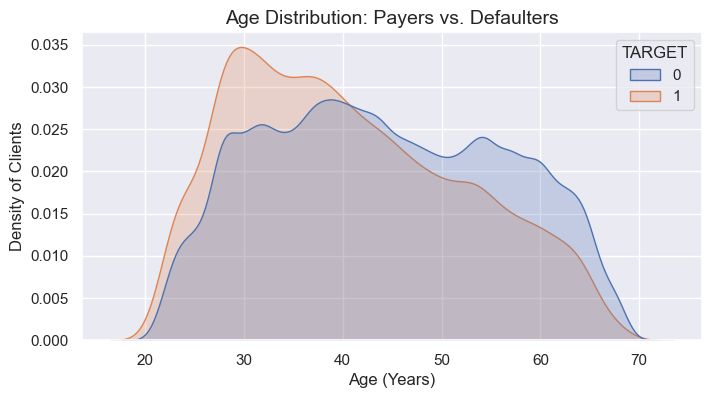

In [166]:
plt.figure(figsize=(8, 4))

# KDE Plot to see the age distribution separated by Target
sns.kdeplot(data=df, x='AGE', hue='TARGET', common_norm=False, fill=True)

plt.title('Age Distribution: Payers vs. Defaulters', fontsize=14)
plt.xlabel('Age (Years)')
plt.ylabel('Density of Clients');

### H2: Capacidade de Pagamento (Debt-to-Income)
**Hipótese:** Clientes que comprometem uma fatia maior de sua renda com o empréstimo (`DEBT_TO_INCOME` alto) têm maior dificuldade de honrar o pagamento.

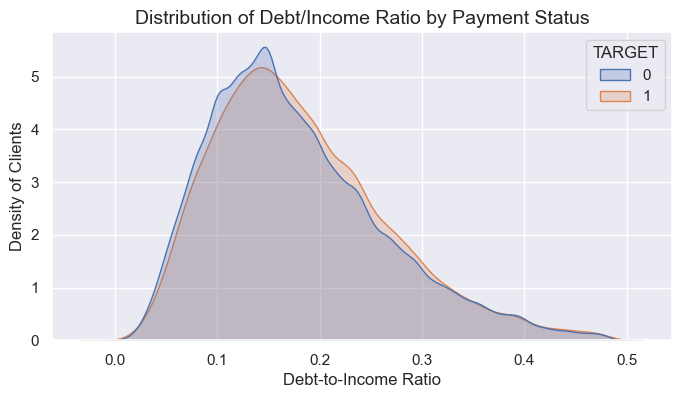

In [167]:
plt.figure(figsize=(8, 4))

# Limiting extreme outliers for visualization (focusing on the 99th percentile)
limit_dti = df['DEBT_TO_INCOME_RATIO'].quantile(0.99)
df_filtered = df[df['DEBT_TO_INCOME_RATIO'] < limit_dti]

sns.kdeplot(data=df_filtered, x='DEBT_TO_INCOME_RATIO', hue='TARGET', common_norm=False, fill=True)

plt.title('Distribution of Debt/Income Ratio by Payment Status', fontsize=14)
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Density of Clients');

### H3: Estabilidade Profissional (Occupation Type)
**Hipótese:** A categoria `Unknown` (clientes que trabalham mas não informaram a profissão) apresenta risco maior do que a categoria `Not Applicable` (Aposentados/Sem emprego). Isso valida a limpeza de dados realizada no Notebook 02.

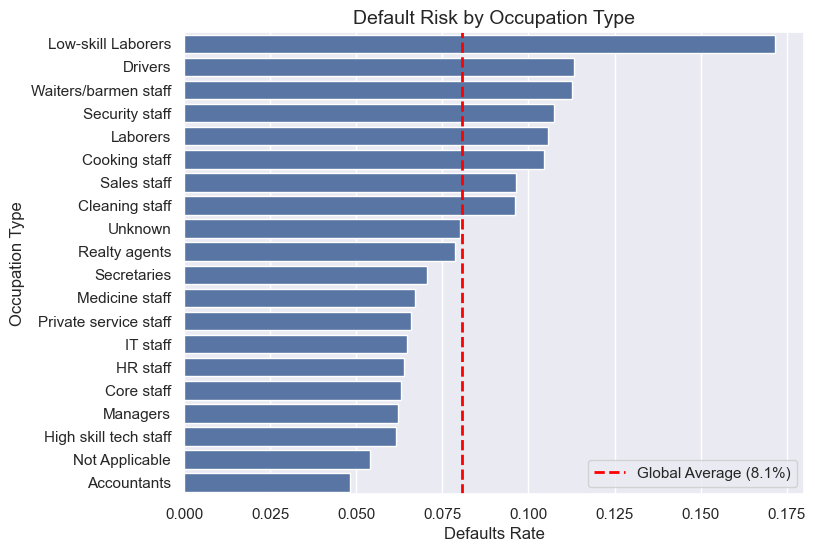

In [168]:
# Preparing the data: Calculating the average default rate by occupation
occ_risk = df.groupby('OCCUPATION_TYPE')['TARGET'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))

# Barplot
sns.barplot(x='TARGET', y='OCCUPATION_TYPE', data=occ_risk)

# Reference Line (Global Average)
plt.axvline(GLOBAL_DEFAULT_RATE, color='red', linestyle='--', linewidth=2, label=f'Global Average ({GLOBAL_DEFAULT_RATE:.1%})')

plt.title('Default Risk by Occupation Type', fontsize=14)
plt.xlabel('Defaults Rate')
plt.ylabel('Occupation Type')
plt.legend();

### H4: Perfil Social (Educação)
**Hipótese:** Clientes com maior nível de escolaridade tendem a possuir maior estabilidade financeira e menor risco de default.

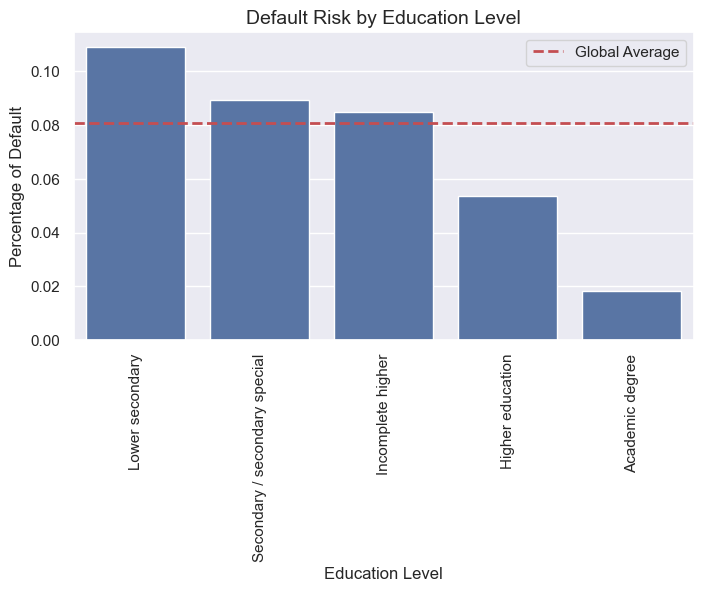

In [169]:
# Preparing the data: Calculating the average default rate by education level
edu_risk = df.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 4))

sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET', data=edu_risk)

# Reference Line (Global Average)
plt.axhline(GLOBAL_DEFAULT_RATE, color='r', linestyle='--', linewidth=2, label='Global Average')
plt.tick_params(axis='x', rotation=90)

plt.title('Default Risk by Education Level', fontsize=14)
plt.xlabel('Education Level')
plt.ylabel('Percentage of Default')
plt.legend();

### H5: Histórico de Crédito Combinado (External Sources Mean)
**Hipótese:** A média dos scores externos (birôs de crédito) é um preditor forte de inadimplência (Histórico de outras instituições diz muito sobre o compromisso do cliente com o pagamento). Clientes com média baixa representam risco extremo.

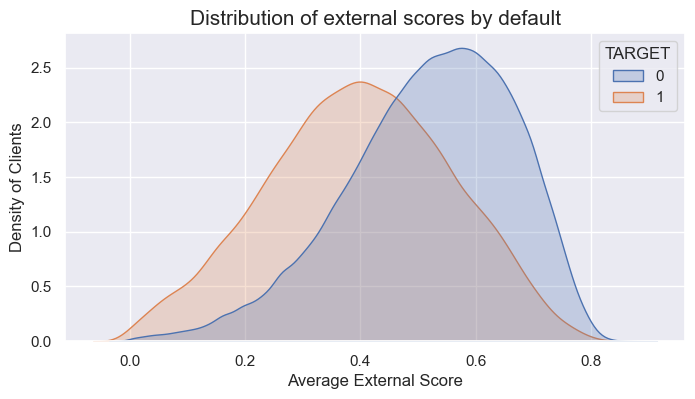

In [170]:
# Creating a new feature: Average of the three external scores
cols_source = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df['EXT_SOURCE_MEAN'] = df[cols_source].mean(axis=1)

plt.figure(figsize=(8, 4))

sns.kdeplot(data=df, x='EXT_SOURCE_MEAN', hue='TARGET', fill=True, common_norm=False)

plt.title('Distribution of external scores by default', fontsize=15)
plt.xlabel('Average External Score')
plt.ylabel('Density of Clients');

### 3.3.1 Resumo da Validação de Hipóteses

Após a análise visual das variáveis principais, consolidamos os seguintes insights para a modelagem:

| Hipótese | Variável(is) | Status | Insight de Negócio |
| :--- | :--- | :--- | :--- |
| **H1: Maturidade** | `AGE` | **Confirmada** | Clientes mais jovens (20-30 anos) possuem risco significativamente maior. A curva de risco decresce com a idade. |
| **H2: Capacidade** | `DEBT_TO_INCOME` | **Rejeitada** | O comprometimento de renda não mostrou separação clara entre pagadores e inadimplentes. Variável com baixo poder preditivo isolado. |
| **H3: Estabilidade** | `OCCUPATION_TYPE` | **Parcial** | A categoria `Unknown` apresenta risco moderado, mas profissões de baixa qualificação (Laborers) são as mais arriscadas. |
| **H4: Social** | `NAME_EDUCATION_TYPE` | **Confirmada** | Forte correlação negativa: Ensino Superior reduz drasticamente a chance de inadimplência. |
| **H5: Histórico** | `EXT_SOURCE_MEAN` | **Forte** | **Melhor preditor.** Scores externos baixos são determinantes para a inadimplência. A separação entre as classes é nítida. |

> **Decisão Estratégica:** Daremos prioridade máxima às variáveis de Histórico (`EXT_SOURCE`) e Demográficas (`AGE`, `EDUCATION`) na modelagem.

## 3.4 Análise de Perfil Demográfico (Scan)
Vamos analisar rapidamente as variáveis categóricas secundárias para garantir que não perdemos nenhum padrão óbvio.

### 3.4.1 Funções Úteis

In [171]:
def plot_risk(feature, label_rotation=False):
    # Create a DataFrame for plotting the quantity of clients in each category
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({
        feature: temp.index,
        'Number of Clients': temp.values
    })

    # Calculate the percentage of target=1 for each category
    cat_perc = df.groupby(feature)['TARGET'].mean().sort_values(ascending=False).reset_index()
    
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

    # Chart 1: Number of Clients by Category
    sns.barplot(x=temp.index, y='Number of Clients', data=df1, ax=axes[0], errorbar=None, order=temp.index)
    axes[0].set_title(f'Number of Clients by {feature}', fontsize=12)
    axes[0].set_ylabel('Number of Clients')

    # Chart 2: Risk (Mean of Target) by Category
    sns.barplot(x=cat_perc[feature], y='TARGET', data=cat_perc, ax=axes[1], errorbar=None, order=cat_perc[feature])
    axes[1].set_title(f'Risk by {feature}', fontsize=12)
    axes[1].set_ylabel('Risk (Mean of Target)')
    axes[1].axhline(GLOBAL_DEFAULT_RATE, color='red', linestyle='--', label='Global Average', linewidth=2)

    if label_rotation:
        axes[0].tick_params(axis='x', rotation=90)
        axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout(pad=2.0)
    plt.show()

### 3.4.2 Variáveis Categóricas
Vamos analisar rapidamente as variáveis categóricas para garantir que não perdemos nenhum padrão óbvio.

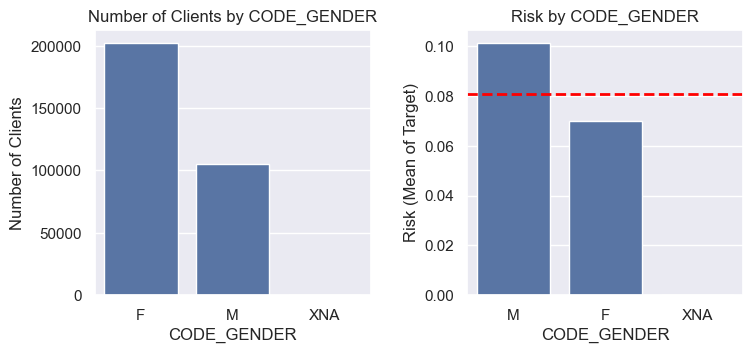

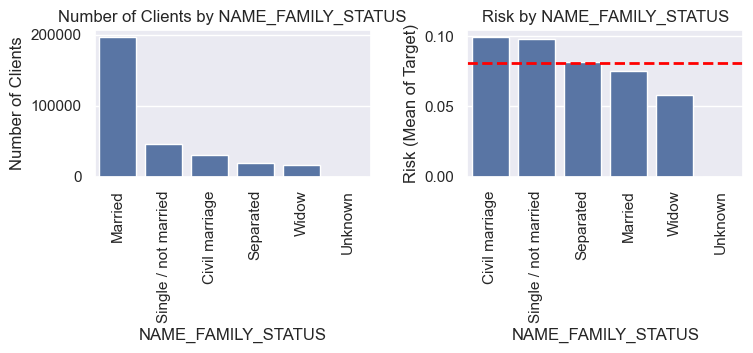

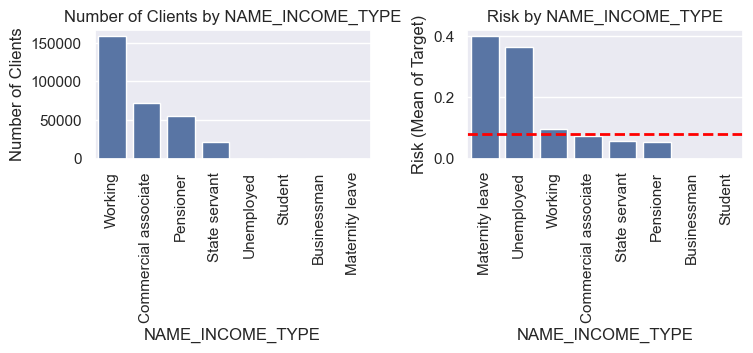

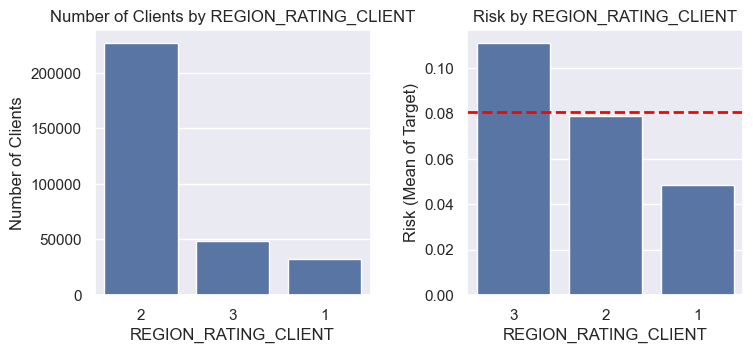

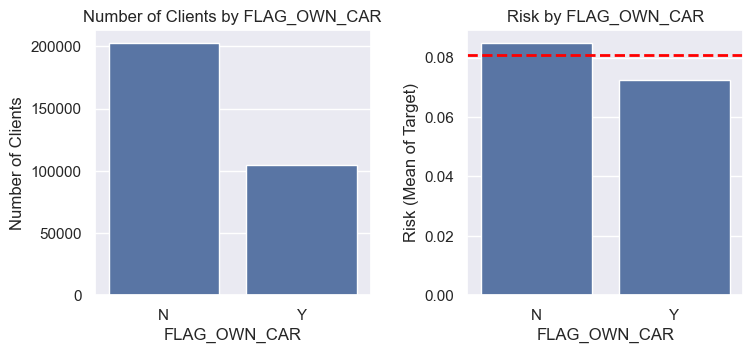

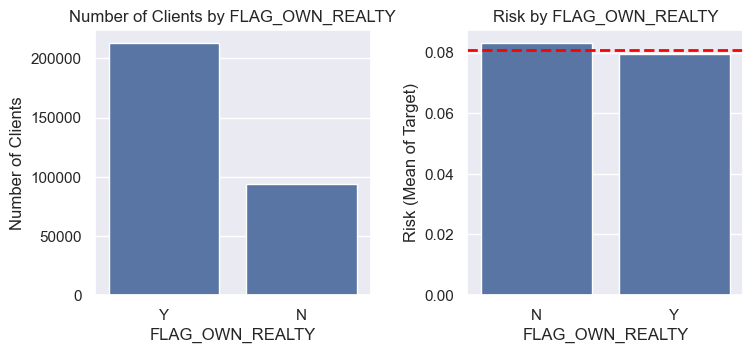

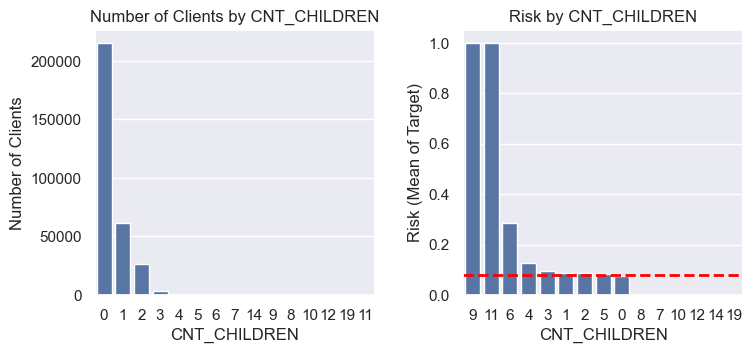

In [172]:
plot_risk('CODE_GENDER')
plot_risk('NAME_FAMILY_STATUS', label_rotation=True)
plot_risk('NAME_INCOME_TYPE', label_rotation=True)
plot_risk('REGION_RATING_CLIENT')
plot_risk('FLAG_OWN_CAR')
plot_risk('FLAG_OWN_REALTY')
plot_risk('CNT_CHILDREN')

Conclusões:
- `CODE_GENDER`: Homens, em média, causam mais inadimplência que as mulheres (menos dados de homens e ainda assim, a porcentagem de TARGET=1 é maior para homens)
- `NAME_FAMILY_STATUS`: O maiores inadimplnetes são os 'casados no civil', seguido dos 'não casados' e 'divorciados'.  
- `NAME_INCOME_TYPE`: Os desempregados e pessoas com licença maternidade apresentam altas taxas de inadimplência.
- `REGION_RATING_CLIENT`: Clientes da região 3 apresentam significativamente uma taxa de inadimplêcia superior (provavelmente a região 3 é uma região mais vulnerável)
- `FLAG_OWN_CAR`: Clientes sem carro apresentam, em média, taxa superior de inadimplência
- `FLAG_OWN_REALTY`: Clientes que não possuem casas possuem taxa de inadimplência pouco superior a média.
- `CNT_CHILDREN`: A maioria dos dados são de pessoas sem filhos (essas são bons pagadores). A partir de 3-4 filhos, a taxa fica acima da média, chegando a valores absursos em 9 e 11 filhos.

## 3.5 Correlações com o Target (Ranking de Importância)
Por último, veremos a **força linear das variáveis numéricas em relação à variável alvo (`TARGET`)**.

Isso nos dirá quais variáveis, isoladamente, têm maior poder de "puxar" o risco para cima ou para baixo.

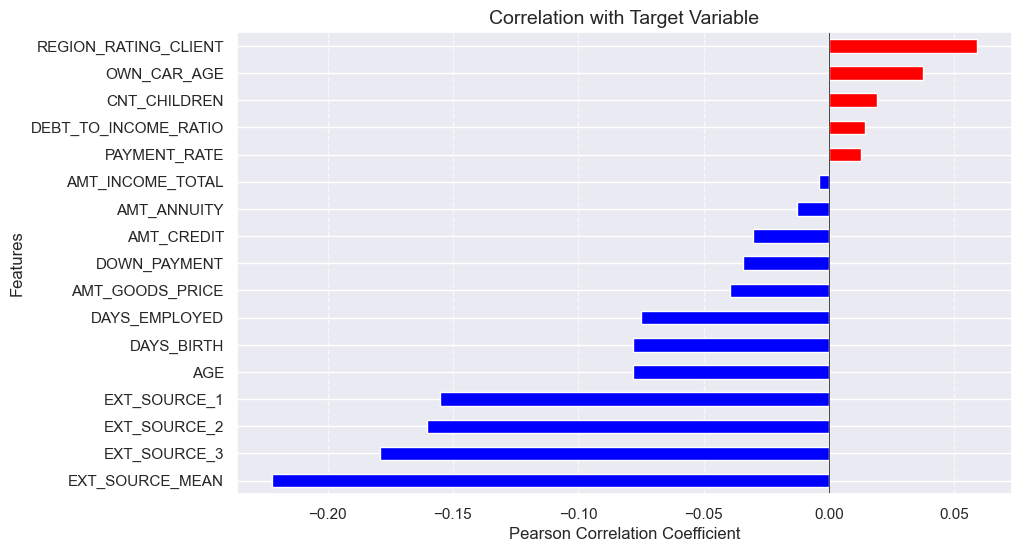

In [183]:
# Calculating correlations
correlations = df.corr(numeric_only=True)['TARGET'].sort_values()

correlations = correlations.drop(['TARGET', 'SK_ID_CURR'])

# Plotting the Ranking
plt.figure(figsize=(10, 6))

# Creating a color gradient: Red (High Risk) vs Blue (Protection)
# Positive Correlation (>0) = Increases chance of being 1 (Defaulter) -> Red
# Negative Correlation (<0) = Decreases chance of being 1 (Payer) -> Blue
colors = ['blue' if x < 0 else 'red' for x in correlations.values]

correlations.plot(kind='barh', color=colors)

plt.title('Correlation with Target Variable', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

O gráfico acima oferece o "mapa do tesouro" para a modelagem preditiva:

1.  **(`EXT_SOURCE_MEAN`):** A barra vermelha mais longa confirma que a média dos scores externos é, de longe, o indicador mais forte de proteção contra inadimplência (Correlação Negativa: Score Alto = Risco Baixo).
2.  **Fatores de Risco (`REGION_RATING`):** Do lado azul, a avaliação da região onde o cliente mora é o maior indicador de risco positivo.
3.  **Validação do Feature Engineering:**
    * **`AGE`:** Confirmada como forte fator de proteção (clientes mais velhos pagam melhor).
    * **`DEBT_TO_INCOME`:** Aparece no lado positivo (azul), confirmando que maior comprometimento de renda aumenta o risco, embora sua força seja menor que a do histórico comportamental.

## 3.6 Conclusão e Próximos Passos

A Análise Exploratória de Dados (EDA) cumpriu seu objetivo de validar a qualidade dos dados e testar as hipóteses de negócio antes da modelagem.

### Principais Insights de Negócio
1.  **Histórico supera Capacidade:** O comportamento histórico do cliente (representado por `EXT_SOURCE` e `AGE`) é um preditor de risco muito mais forte do que a capacidade financeira momentânea (`INCOME`, `DEBT_TO_INCOME`).
2.  **O Perfil de Segurança:** O cliente ideal é mais velho, possui ensino superior, score externo alto e estabilidade no emprego (anos trabalhados).
3.  **O Perfil de Risco:** Jovens (< 30 anos), com profissões de baixa qualificação ou omitidas (`Unknown`) e residentes em regiões com baixo rating comercial.

### Impacto na Estratégia de Modelagem
Com base nestes resultados, definimos a estratégia para o próximo passo (Machine Learning):
* **Feature Selection:** Daremos peso prioritário para `EXT_SOURCE_MEAN`, `AGE`, `DAYS_EMPLOYED` e `EDUCATION`.
* **Feature Engineering Validada:** As variáveis criadas `EXT_SOURCE_MEAN` e `AGE` provaram seu valor e serão mantidas. A variável `DEBT_TO_INCOME` será mantida como feature secundária.
* **Expectativa:** Esperamos que modelos baseados em árvores (como Random Forest ou XGBoost) capturem bem as não-linearidades identificadas na idade e no score externo.

---
**Status do Projeto:** Dataset validado e pronto para Modelagem.